In [1]:
import zipfile
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from keras.utils import get_custom_objects
from keras.models import Model
from keras.applications import InceptionResNetV2, MobileNetV2, EfficientNetB0, ResNet50

import numpy as np


2025-07-10 13:59:33.206606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752155973.361522      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752155973.410610      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_dir = "/kaggle/input/teeth-cellula/Teeth_Dataset/Training"
val_dir   = "/kaggle/input/teeth-cellula/Teeth_Dataset/Validation"
test_dir  = "/kaggle/input/teeth-cellula/Teeth_Dataset/Testing"

In [3]:
train_datagen= ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
     fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle= False)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [5]:
def build_model(base_model_fn, input_shape=(224,224,3), n_classes=7):
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [6]:
models_to_test = {
    "InceptionResNetV2": InceptionResNetV2,
    "MobileNetV2": MobileNetV2,
    "ResNet50": ResNet50
}

In [7]:
results = {}
histories= {}
for name, base_fn in models_to_test.items():
    print(f"\nTraining model: {name}")
    
    model = build_model(base_fn)

    
    checkpoint = ModelCheckpoint(
    filepath=f"{name}_best_model.h5",  
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1)

    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=50,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10),checkpoint],
        verbose=1
    )
    
    score = model.evaluate(val_generator, verbose=0)
    results[name] = {
        "val_loss": score[0],
        "val_accuracy": score[1]
    }
    histories[name] = history




Training model: InceptionResNetV2


I0000 00:00:1752156011.290063      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1752156052.446325     102 service.cc:148] XLA service 0x7e5fd8004f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752156052.447081     102 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752156056.939289     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/97 ━━━━━━━━━━━━━━━━━━━━ 1:00:22 38s/step - accuracy: 0.1875 - loss: 2.3674

I0000 00:00:1752156064.481072     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.2740 - loss: 1.9967
Epoch 1: val_accuracy improved from -inf to 0.49416, saving model to InceptionResNetV2_best_model.h5
97/97 ━━━━━━━━━━━━━━━━━━━━ 110s 750ms/step - accuracy: 0.2747 - loss: 1.9941 - val_accuracy: 0.4942 - val_loss: 1.4148
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.4503 - loss: 1.4412
Epoch 2: val_accuracy improved from 0.49416 to 0.57393, saving model to InceptionResNetV2_best_model.h5
97/97 ━━━━━━━━━━━━━━━━━━━━ 37s 378ms/step - accuracy: 0.4506 - loss: 1.4406 - val_accuracy: 0.5739 - val_loss: 1.1648
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.5230 - loss: 1.2237
Epoch 3: val_accuracy improved from 0.57393 to 0.64591, saving model to InceptionResNetV2_best_model.h5
97/97 ━━━━━━━━━━━━━━━━━━━━ 37s 386ms/step - accuracy: 0.5231 - loss: 1.2236 - val_accuracy: 0.6459 - val_loss: 0.9989
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.5683 - loss: 1.1488
Epo

KeyboardInterrupt: 

In [11]:
model = load_model("MobileNetV2_best_model.h5")
model.save("MobileNetV2_best_model_fixed.keras")  


In [12]:
df = pd.DataFrame(results).T
df = df.sort_values(by="val_accuracy", ascending=False)
print(df)

                   val_loss  val_accuracy
MobileNetV2        0.060463      0.987354
InceptionResNetV2  0.231277      0.928988


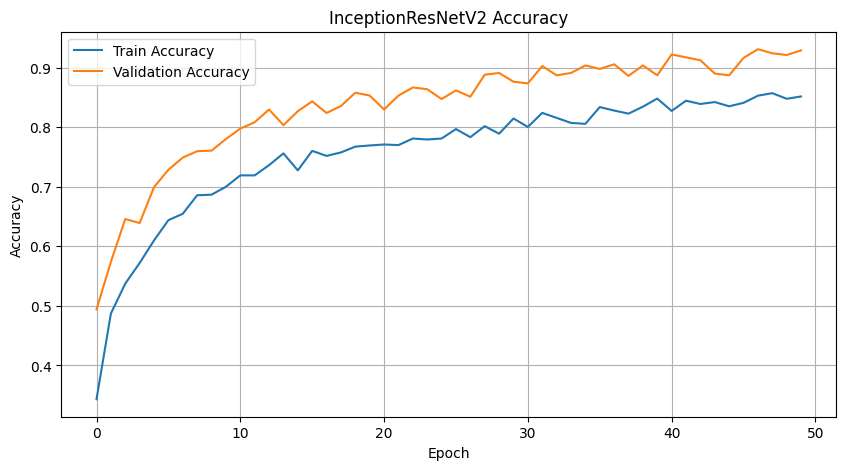

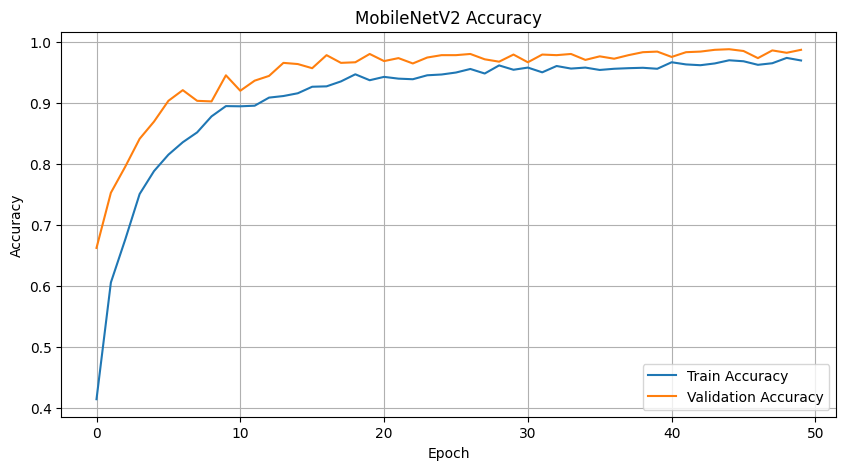

In [13]:
for name, history in histories.items():
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{name} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


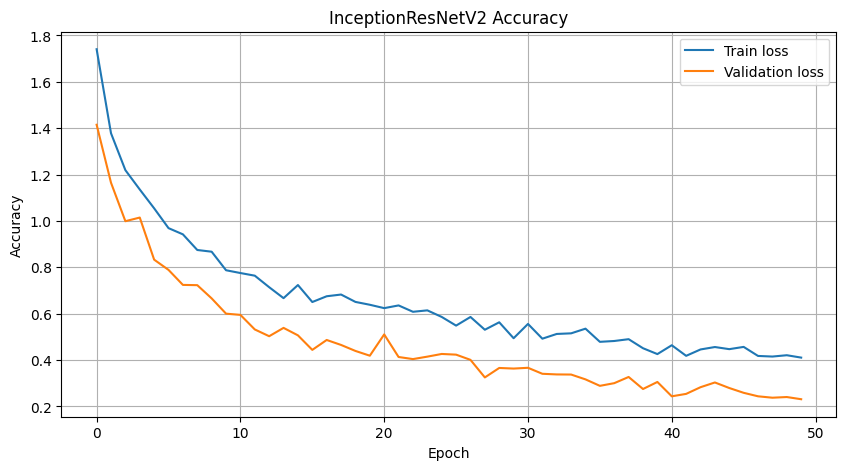

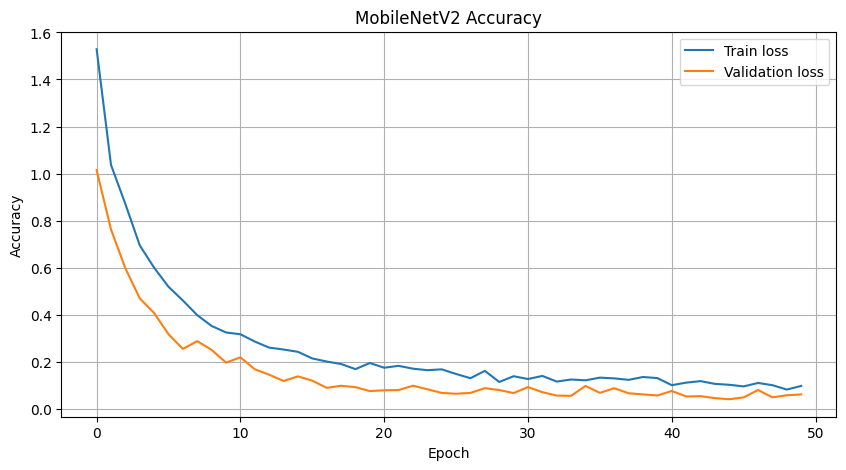

In [14]:
for name, history in histories.items():
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title(f"{name} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()